In [123]:
import salem as sa
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyproj import Proj
import numpy as np
import pandas as pd

In [8]:
data_base_folder = Path('/home/ben/data/GAR/')
project = 'rc_trop_ls'

In [9]:
color_map = LinearSegmentedColormap.from_list(
    "mycmap",
    ["white", "steelblue", "c", "khaki", "orange", "orangered", "r", "darkred"],
)

def plot_map(ax, ds, model, cmap, scalebar=False):
    smap = ds.salem.get_map(data=model, cmap=cmap, vmin=0, vmax=1020)
    x, y = smap.grid.transform(lons, lats)
    smap.set_shapefile(countries=False)
    smap.set_lonlat_contours(xinterval=1)
    if scalebar:
        smap.set_scale_bar(location=(0.85, 0.08))
    smap.visualize(addcbar=False)
    return smap

In [53]:
grid = sa.mercator_grid(center_ll=(-90, 0), extent=(100000, 100000))
oceans = sa.read_shapefile(sa.get_demo_file('ne_50m_ocean.shp'),
                              cached=True)
grid

<salem.Grid>
  proj: +datum=WGS84 +k=0.9996 +lat_0=0 +lon_0=-90 +no_defs+proj=tmerc +units=m +x_0=0 +y_0=0
  pixel_ref: corner
  origin: lower-left
  (nx, ny): (600, 600)
  (dx, dy): (166.66666666666666, 166.66666666666666)
  (x0, y0): (-50000.0, -50000.0)

In [11]:
def open_dataset(file, pyproj_srs='+proj=merc +lat_0=2 +lon_0=-89.5 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'):
    data_base_folder = Path('/home/ben/data/GAR/')
    ds = xr.open_dataset(
        data_base_folder/file,
        decode_cf=False
    )
    split = file.split('/')[-1].split('_')
    var = split[-2]
    if var == 'lu':
        var = split[-2] + '_' + split[-1].split('.')[0]
    ds[var].attrs['pyproj_srs'] = pyproj_srs
    return ds

In [28]:
proj_string = '+proj=merc +lat_0=2 +lon_0=-90.32 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [117]:
ds

<xarray.Dataset>
Dimensions:      (time: 91, west_east: 245, south_north: 230)
Coordinates:
  * time         (time) int32 90 91 92 93 94 95 96 ... 175 176 177 178 179 180
  * west_east    (west_east) float32 -2.44e+05 -2.42e+05 ... 2.42e+05 2.44e+05
  * south_north  (south_north) float32 -2.74e+05 -2.72e+05 ... 1.82e+05 1.84e+05
Data variables:
    lon          (south_north, west_east) float32 -92.51 -92.49 ... -88.11
    lat          (south_north, west_east) float32 -2.465 -2.465 ... 1.656 1.656
    et           (south_north, west_east) float32 nan nan nan ... nan nan nan
Attributes: (12/25)
    CDI:               Climate Data Interface version 1.9.9rc1 (https://mpime...
    Conventions:       CF-1.6
    history:           Fri Aug 26 13:55:02 2022: cdo selmonth,04/06 rc_trop_l...
    TITLE:             DARWIN rc
    DATA_NOTES:        File generated with the output of successive model run...
    WRF_VERSION:        OUTPUT FROM WRF V4.3.3 MODEL
    ...                ...
    DY:                2000.0
    X0:                   -244000.0
    Y0:                   -274001.4
    PRODUCT_LEVEL:     d
    LEVEL_INFO:        H: original simulation output; D: daily; M: monthly; Y...
    CDO:               Climate Data Operators version 1.9.9rc1 (https://mpime...

In [166]:
def find_lonlat(ds, var, lon, lat):
    abslat = np.abs(ds.lat-lat)
    abslon = np.abs(ds.lon-lon)
    c = np.maximum(abslon, abslat)
    ([xlon], [xlat]) = np.where(c == np.min(c))
    selected = ds.isel(west_east=xlon, south_north=xlat)
    return pd.Series(selected[var])

<AxesSubplot:>

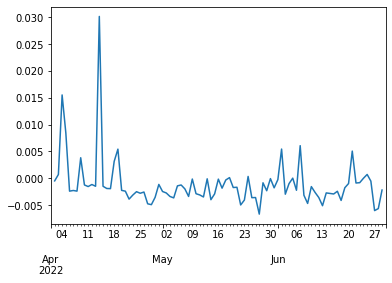

In [174]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_et_2022.nc',
    proj_string
)
minas_rojas = find_lonlat(ds, "et", -90.3673, -0.618625)
# selected = ds.isel(west_east=minas_rojas[0], south_north=minas_rojas[1])
# selected = select_lonlat(ds, -90.3673, -0.618625)
minas_rojas.index = pd.DatetimeIndex(pd.date_range('2022-04-01','2022-06-30'))
minas_rojas.plot()

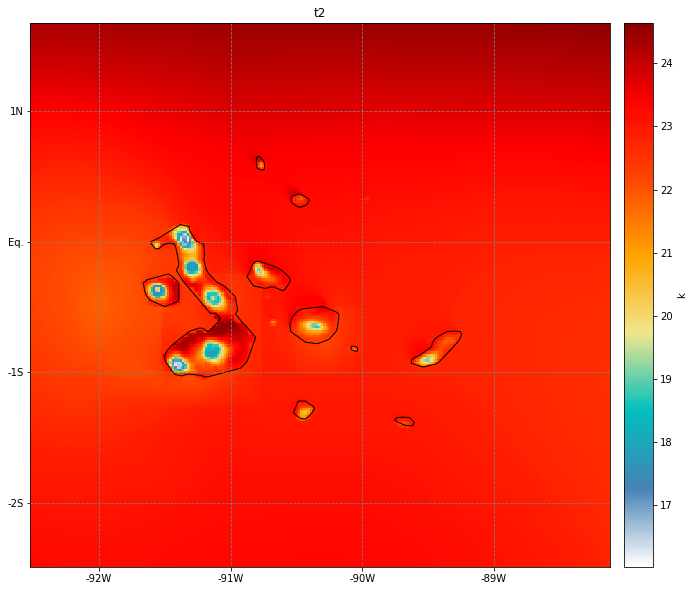

In [29]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_t2_2022.nc',
    proj_string
)
ds.t2.data = ds.t2.data - 273.15
ds["t2"] = ds.t2.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('t2')
ds.t2.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

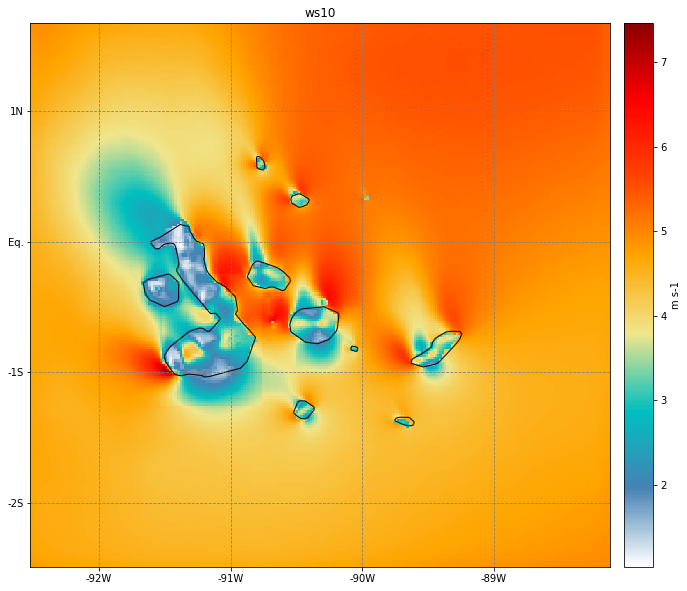

In [34]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_ws10_2022.nc',
    proj_string
)
ds.ws10.data = ds.ws10.data
ds["ws10"] = ds.ws10.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('ws10')
ds.ws10.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

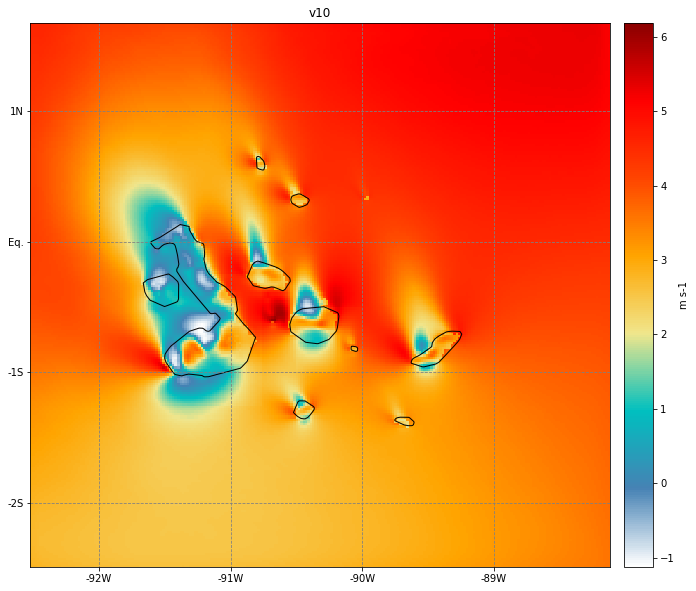

In [37]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_v10_2022.nc',
    proj_string
)
ds["v10"] = ds.v10.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('v10')
ds.v10.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

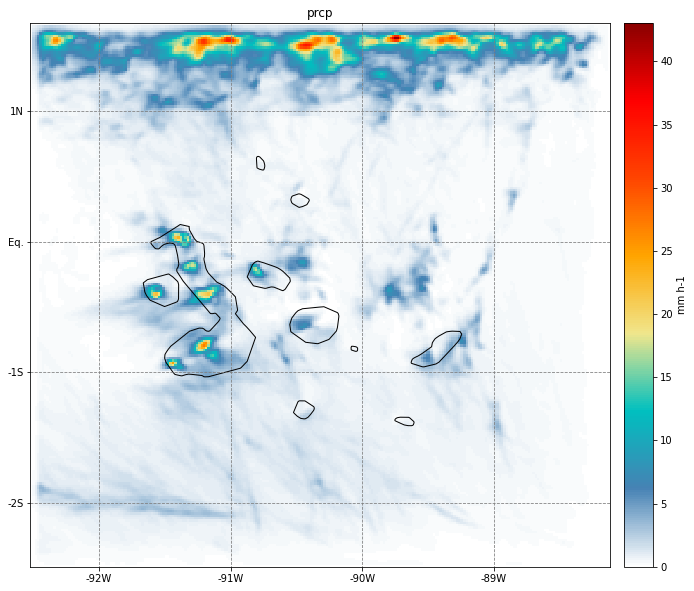

In [61]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_prcp_2022.nc',
    proj_string
)
ds.prcp.data = ds.prcp.data
ds["prcp"] = ds.prcp.sum(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
ds.prcp.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

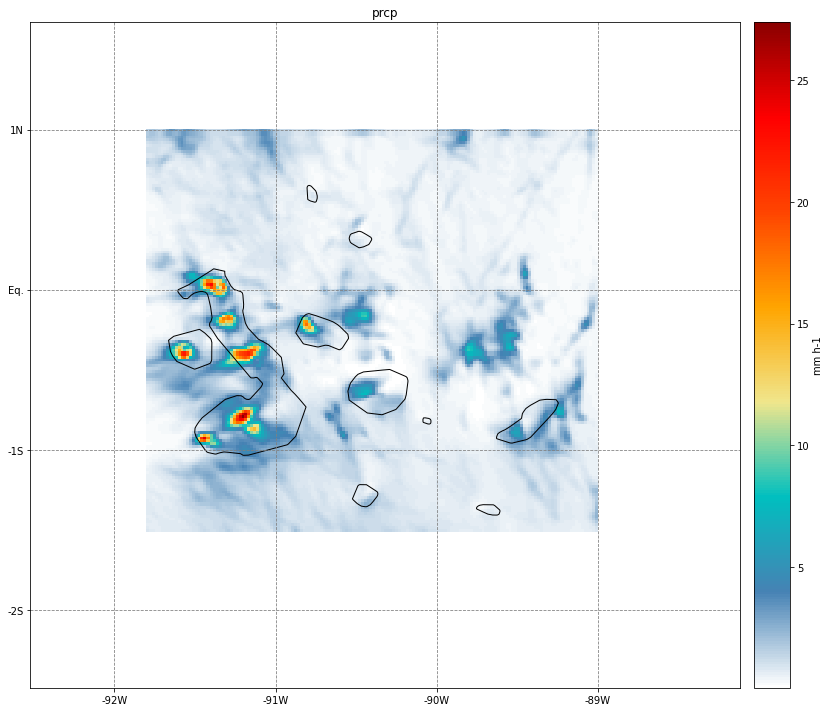

In [70]:

ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_prcp_2022.nc',
    proj_string
)
fig, ax = plt.subplots(figsize=(12, 10))
ds["prcp"] = ds.prcp.sum(dim='time', skipna=True, keep_attrs=True)
# mask_all_touched = ds.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched = ds.prcp.salem.roi(shape=oceans, corners=((-91.8, -1.5), (-89, 1)), all_touched=True)
ds["prcp"].data = mask_all_touched
ds.prcp.salem.quick_map(ax=ax, cmap=color_map)
plt.tight_layout()
plt.show()

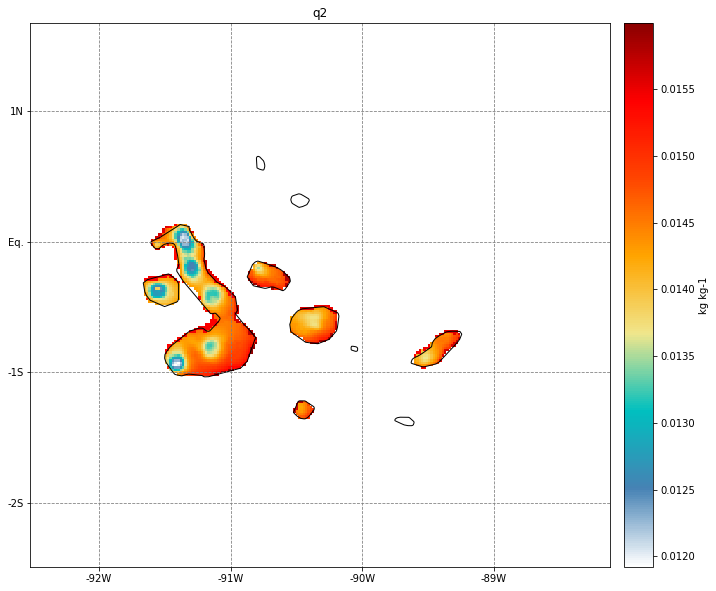

In [80]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_q2_2022.nc',
    proj_string
)
ds["q2"] = ds.q2.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.q2.salem.roi(shape=oceans, all_touched=True)
ds["q2"].data = mask_all_touched
ds.q2.salem.quick_map(ax=ax, cmap=color_map)

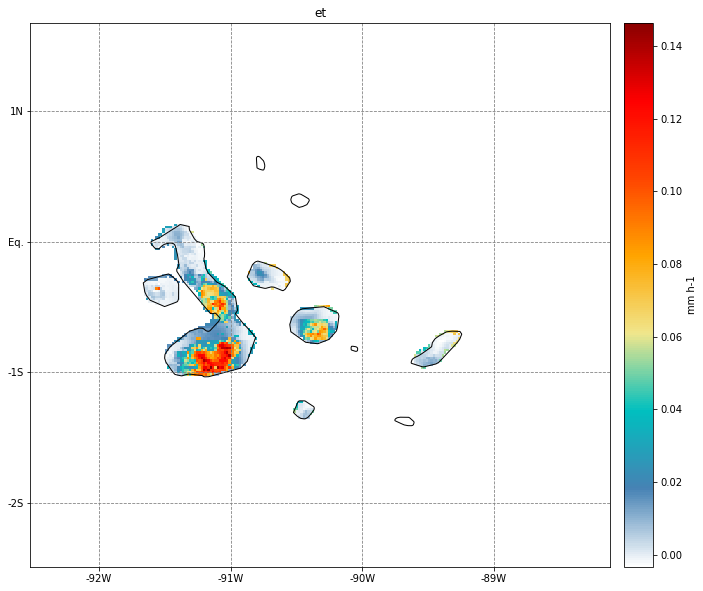

In [83]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_et_2022.nc',
    proj_string
)
ds["et"] = ds.et.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.et.salem.roi(shape=oceans, all_touched=True)
ds["et"].data = mask_all_touched
ds.et.salem.quick_map(ax=ax, cmap=color_map)

In [84]:
l_prcp = open_dataset(
    'rc_trop_l/products/d10km_d02/d/2d/rc_test_large_tropical_d10km_d02_d_2d_prcp_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

m_prcp = open_dataset(
    'rc_trop/products/d10km_d02/d/2d/rc_trop_d10km_d02_d_2d_prcp_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

s_prcp = open_dataset(
    'rc_trop_s/products/d02/d/2d/rc_trop_s_d10km_d02_d_2d_prcp_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ls_prcp = open_dataset(
    'rc_trop_s/products/d02/d/2d/rc_trop_s_d10km_d02_d_2d_prcp_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

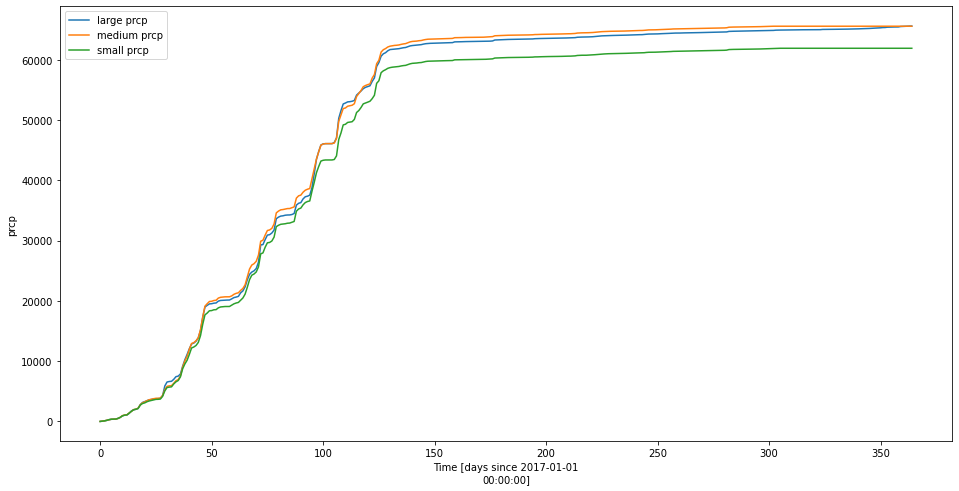

In [85]:
fig, ax = plt.subplots(figsize=(16,8))
mask_all_touched = l_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.sum(axis=(1,2)).cumsum().plot(ax=ax, label="large prcp")
# l_prcp.prcp.sum(axis=(1,2)).cumsum().plot(ax=ax, label="large prcp")
mask_all_touched = m_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.sum(axis=(1,2)).cumsum().plot(ax=ax, label="medium prcp")
# m_prcp.prcp.sum(axis=(1,2)).cumsum().plot(ax=ax, label="medium prcp")
mask_all_touched = s_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.sum(axis=(1,2)).cumsum().plot(ax=ax, label="small prcp")
# s_prcp.prcp.sum(axis=(1,2)).cumsum().plot(ax=ax, label="small prcp")
ax.legend()
plt.savefig("domain_sizes_prcp_land.png")
plt.show()

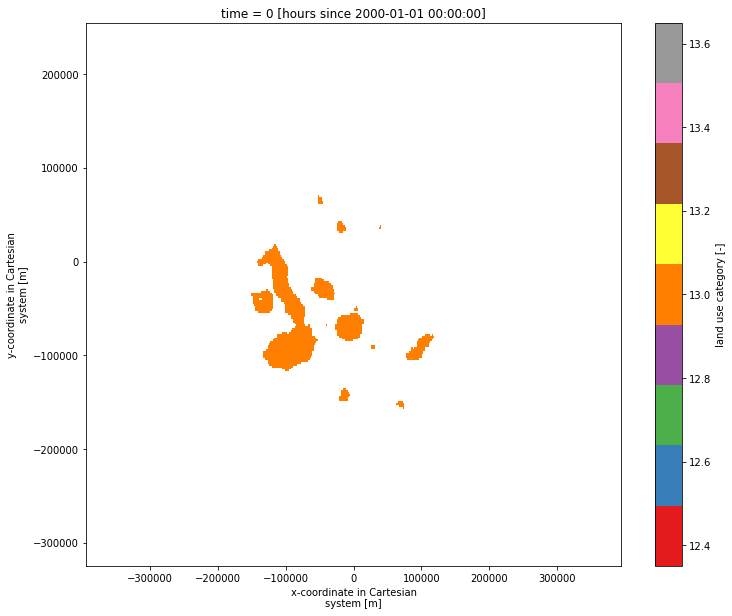

In [101]:
# plot land cover static data
lu_index = open_dataset(
    'rc_trop_l/products/d10km_d02/static/rc_test_large_tropical_d10km_d02_static_lu_index.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
lu_index.lu_index.data[lu_index.lu_index.data == 16] = np.nan

lu_index.lu_index.plot(cmap='Set1', figsize=(12,10))
plt.savefig('lu_index.png')

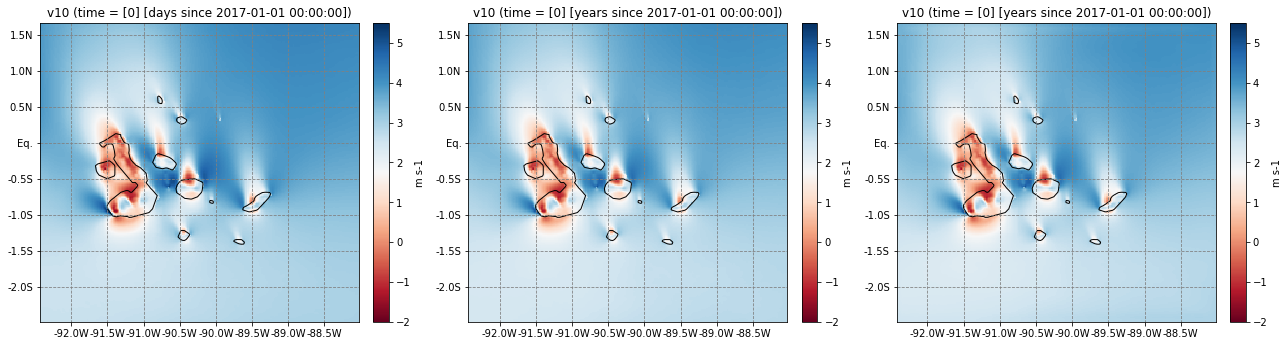

In [190]:
v10_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m = v10_m.v10.salem.subset(grid=v10_s.v10.salem.grid)
v10_l = v10_l.v10.salem.subset(grid=v10_s.v10.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
v10_s.v10.salem.quick_map(ax=ax3, cmap='RdBu', vmin=-2, vmax=5.5)
v10_m.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2, vmax=5.5)
v10_l.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2, vmax=5.5)
plt.tight_layout()
plt.savefig('v10_domains.png')
plt.show()

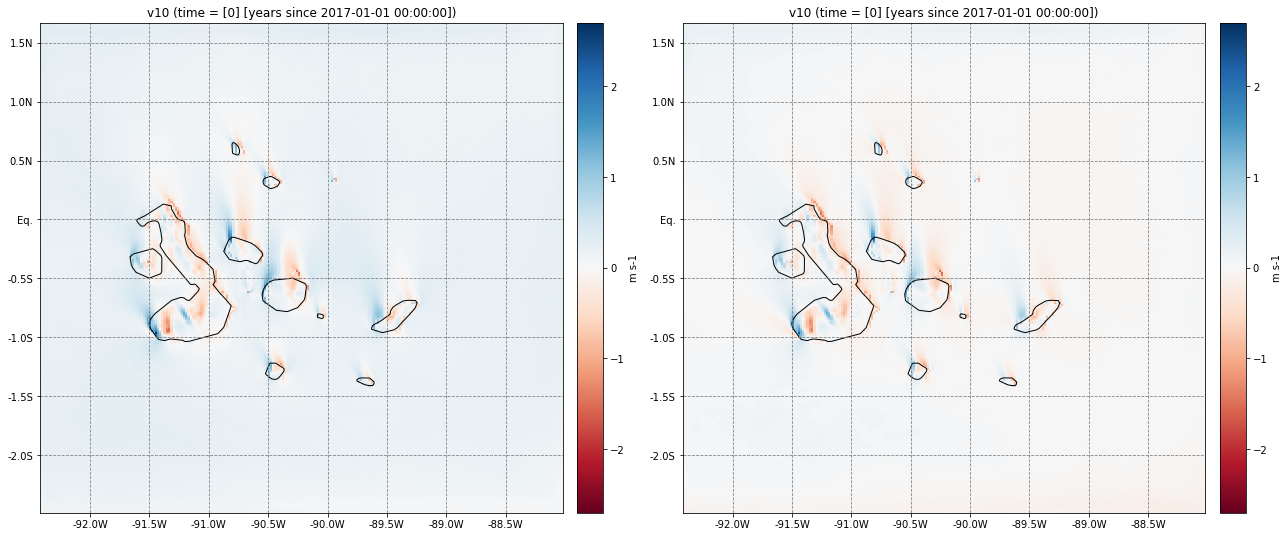

In [194]:
v10_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_l_s.v10.data = (v10_l.data - v10_s.v10.data)
v10_m_s.v10.data = (v10_m.data - v10_s.v10.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
v10_l_s.v10.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2.7, vmax=2.7)
v10_m_s.v10.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2.7, vmax=2.7)
plt.tight_layout()
plt.savefig('v10_compare.png')
plt.show()

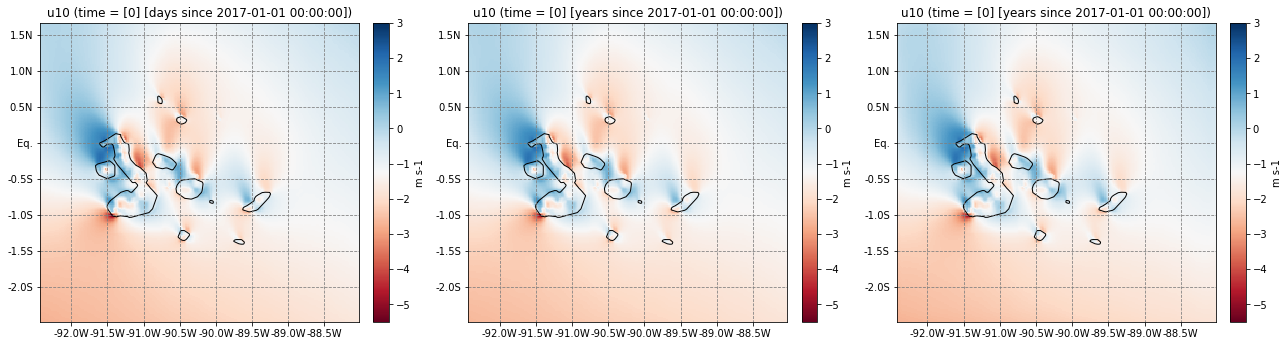

In [201]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='RdBu', vmin=-5.5, vmax=3, )
ws_m.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-5.5, vmax=3)
ws_l.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-5.5, vmax=3)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

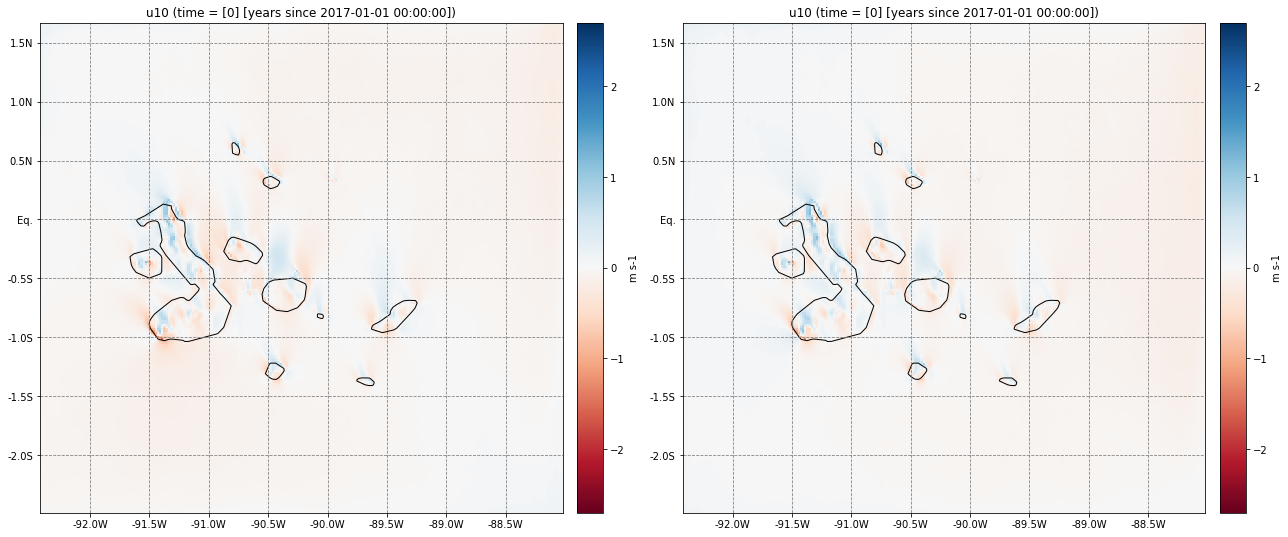

In [203]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2.7, vmax=2.7)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2.7, vmax=2.7)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

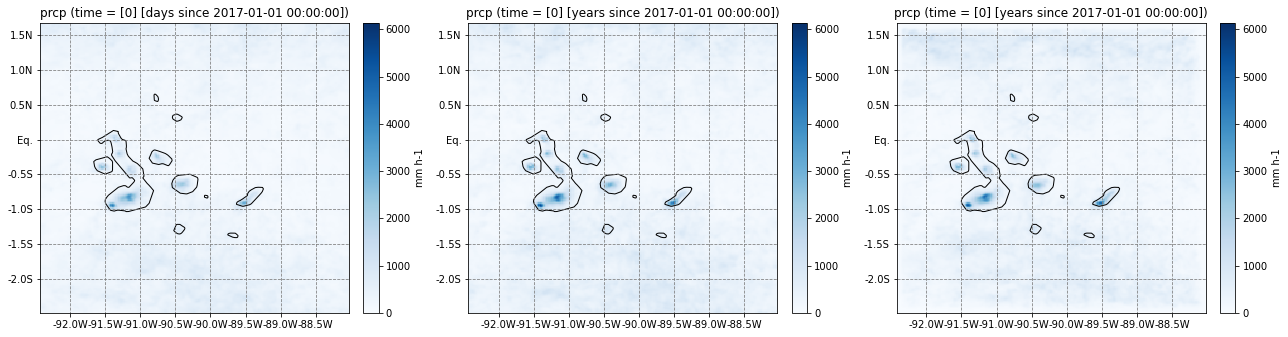

In [226]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l.ws.data = ws_l.ws.data * 24 * 365
ws_m.ws.data = ws_m.ws.data * 24 * 365
ws_s.ws.data = ws_s.ws.data * 24 * 365
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365, )
ws_m.salem.quick_map(ax=ax2, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365)
ws_l.salem.quick_map(ax=ax1, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

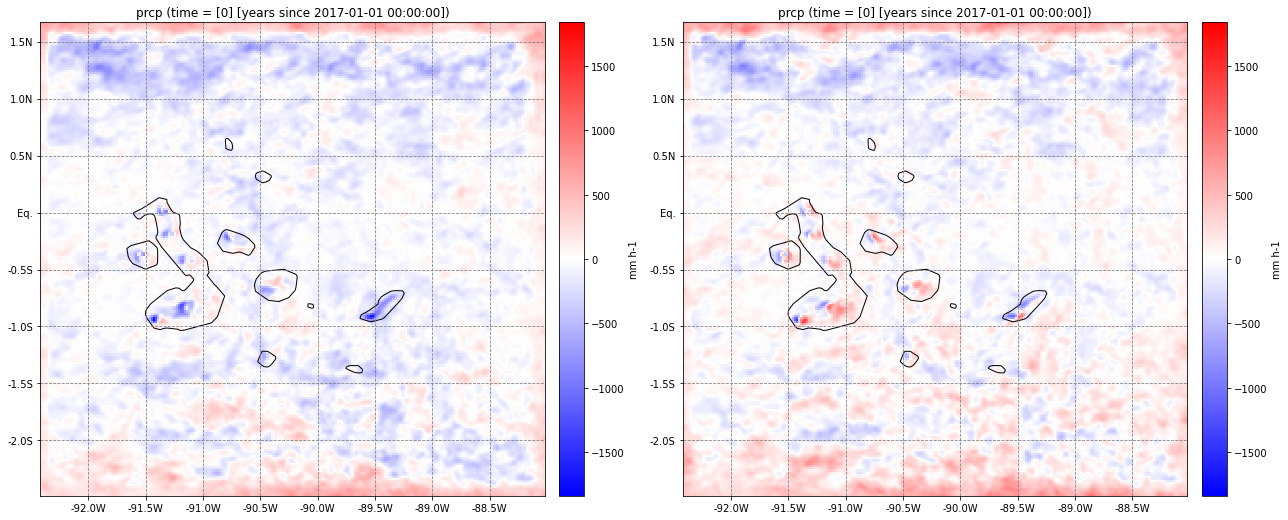

In [229]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='bwr', vmin=-.21 * 24 * 365, vmax=.21 * 24 * 365)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='bwr', vmin=-.21 * 24 * 365, vmax=.21 * 24 * 365)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

In [235]:
ws_l.sel(pressure=500)

<xarray.DataArray 'ws' (time: 1, south_north: 230, west_east: 245)>
array([[[6.49867 , 6.499325, ..., 6.904687, 6.906721],
        [6.501864, 6.50249 , ..., 6.908195, 6.911171],
        ...,
        [6.902314, 6.90386 , ..., 7.376873, 7.378186],
        [6.902701, 6.904034, ..., 7.375025, 7.37688 ]]], dtype=float32)
Coordinates:
  * time         (time) int32 0
  * west_east    (west_east) float32 -2.36e+05 -2.34e+05 ... 2.5e+05 2.52e+05
  * south_north  (south_north) float32 -2.74e+05 -2.72e+05 ... 1.82e+05 1.84e+05
    pressure     float32 500.0
Attributes:
    long_name:   horizontal wind speed on mass grid points
    units:       m s-1
    agg_method:  mean
    pyproj_srs:  +proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=...

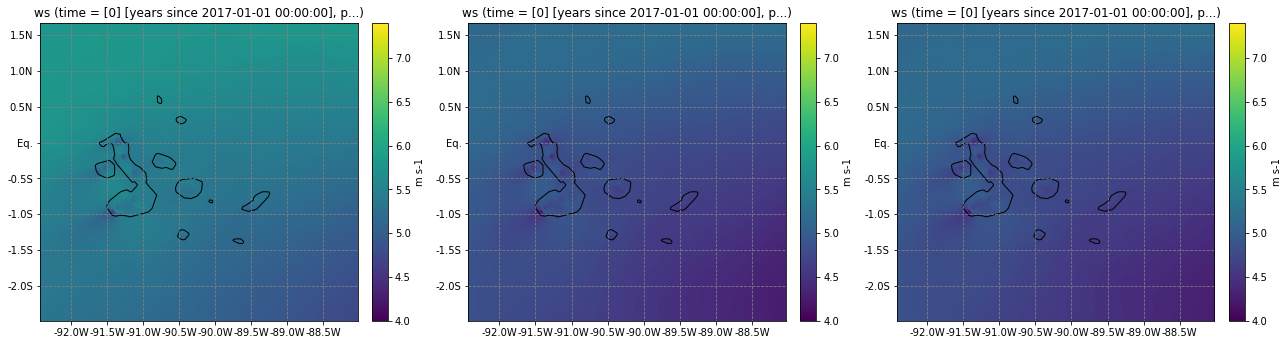

In [254]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/3d_press/rc_trop_l_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/3d_press/rc_trop_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l = ws_l.sel(pressure=800)
ws_m = ws_m.sel(pressure=800)
ws_s = ws_s.sel(pressure=800)
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='viridis', vmin = 4, vmax = 7.4)
ws_m.salem.quick_map(ax=ax2, cmap='viridis', vmin = 4, vmax = 7.4)
ws_l.salem.quick_map(ax=ax1, cmap='viridis', vmin = 4, vmax = 7.4)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

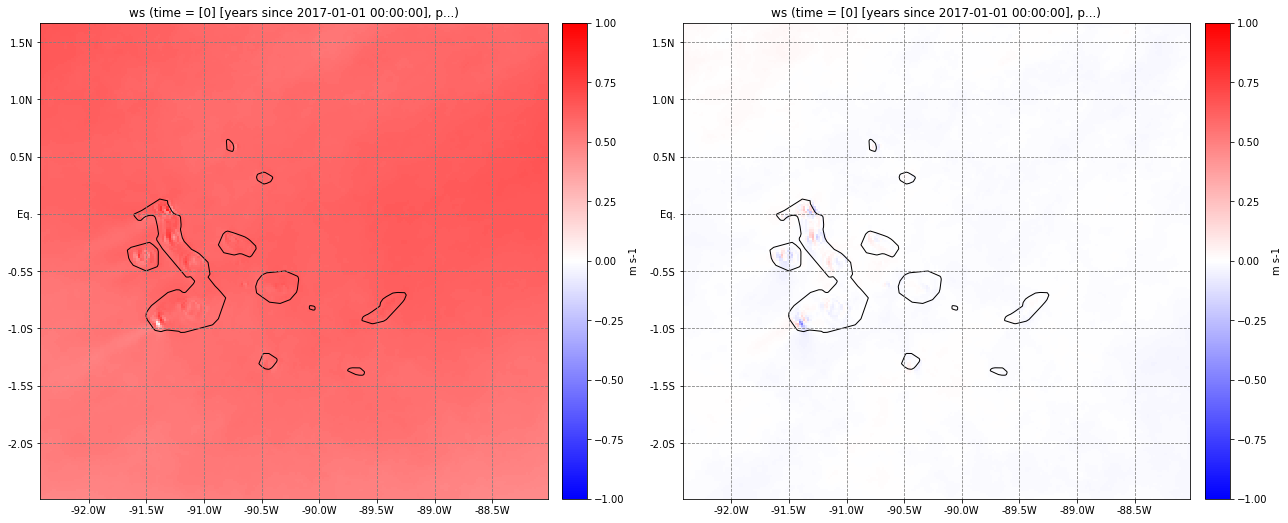

In [255]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

ws_l_s = ws_l_s.sel(pressure=800)
ws_m_s = ws_m_s.sel(pressure=800)

ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='bwr', vmin=-1, vmax=1)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='bwr', vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()